# Computing moments after cell dvision

(c) 2020 Manuel Razo. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT). 

---

In [1]:
import os
import pickle
import glob
import cloudpickle
import git

import itertools # Library we'll use to generate possible pairs of numbers

# Numerical workhorse
import numpy as np
import pandas as pd

# To compute symbolic expressions
import sympy
sympy.init_printing(use_unicode=True, use_latex=True) # print outputs in LaTeX

# Import matplotlib stuff for plotting
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

# Seaborn, useful for graphics
import seaborn as sns

# This enables high resolution graphics inline
%config InlineBackend.figure_format = 'retina'


# Import the project utils
import ccutils

# Find home directory for repo
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

tmpdir = f'{homedir}/tmp/'
figdir = f'{homedir}/fig/moment_dynamics_numeric/'
datadir = f'{homedir}/data/csv_maxEnt_dist/'

In [2]:
# Set PBoC plotting format
ccutils.viz.set_plotting_style()
# Increase dpi
mpl.rcParams['figure.dpi'] = 110

### $\LaTeX$ macros
$\newcommand{kpon}{k^{(p)}_{\text{on}}}$
$\newcommand{kpoff}{k^{(p)}_{\text{off}}}$
$\newcommand{kron}{k^{(r)}_{\text{on}}}$
$\newcommand{kroff}{k^{(r)}_{\text{off}}}$
$\newcommand{rm}{r _m}$
$\newcommand{gm}{\gamma _m}$
$\newcommand{ee}[1]{\left\langle #1 \right\rangle}$
$\newcommand{bb}[1]{\mathbf{#1}}$
$\newcommand{th}[1]{{#1}^{\text{th}}}$
$\newcommand{dt}[1]{{\partial{#1} \over \partial t}}$
$\newcommand{Km}{\bb{K}}$
$\newcommand{Rm}{\bb{R}_m}$
$\newcommand{Re}{\bb{R}_m'}$
$\newcommand{Gm}{\bb{\Gamma}_m}$
$\newcommand{Rp}{\bb{R}_p}$
$\newcommand{Gp}{\bb{\Gamma}_p}$

## Computing the moments of the distribution after cell division.

We have already solved a general form for the dynamics of the moments of the distribution, i.e. we wrote differential equations for the moments ${d\ee{m^x p^y}\over dt}$. Given that we know all parameters for our model we can simply integrate these equations numerically to compute how the moments of the distribution evolve as cells progress through their cell cycle. Once the cell reaches a time $t_d$ when is going to divide the mRNA and proteins that we are interested in undergo a binomial partitioning between the two daughter cells. In other words each molecule flips a coin and decides whether to go to either daughter. The question then becomes given that we have a value for the moment $\ee{m^x p^y}_{t_d}$ at a time before the cell division, what would the value of this moment be after the cell division takes place $\ee{m^x p^y}_{t_o}$?

We know that the probability distribution of mRNA and protein after the cell division $P_{t_o}(m, p)$ is of the form
$$
P_{t_o}(m, p) = \sum_{m', p'} P(m, p \mid m', p') P_{t_d}(m', p'),
$$
where we are basically summing over all the possibilities of having $m'$ mRNA and $p'$ proteins before cell division. The conditional probability $P(m, p \mid m', p')$ is simply given by a product of two binomial distributions, one for the mRNA and one for the protein; this is
$$
P(m, p \mid m', p') = {m' \choose m}\left( {1 \over 2} \right)^{m'}
{p' \choose p}\left( {1 \over 2} \right)^{p'}.
$$
This is because the partitionining of mRNA and protein between cells is independent of each other.

Given this functional form we can then compute the moments after the cell division $\ee{m^x p^y}_{t_o}$ as
$$
\ee{m^x p^y}_{t_o} = \sum_m \sum_p m^x p^y P_{t_o}(m, p).
$$
Substituting the definition of the probability distribution results in
$$
\ee{m^x p^y}_{t_o} = \sum_m \sum_p m^x p^y
\sum_{m', p'} P(m, p \mid m', p') P_{t_d}(m', p').
$$
We can rearange the sums to be 
$$
\ee{m^x p^y}_{t_o} = \sum_{m', p'} P_{t_d}(m', p')
\sum_m \sum_p m^x p^y
P(m, p \mid m', p').
$$
We mentioned that the partitioning of mRNA and protein between daughter cells are independent events. This can be expressed as
$$
P(m, p \mid m', p') = P(m \mid m') \cdot P(p \mid p').
$$
With this we can then write the moment $\ee{m^x p^y}_{t_o}$ as
$$
\ee{m^x p^y}_{t_o} = \sum_{m', p'} P_{t_d}(m', p')
\sum_m  m^x  P(m \mid m')
\sum_p p^y P(p \mid p').
$$
Notice that the terms with the conditional distributions are of the form
$$
\sum_z  z^x  P(z \mid z') \equiv \ee{z^x \mid z'}, \; 
{\text{ for } z\in \{m, p \}},
$$
i.e. conditional expected values. These conditional expected values are the expected values of a binomial random variable $z \sim \text{Bin}(z', 1/2)$. We can then rewrite the expected values after the cell division as
$$
\ee{m^x p^y}_{t_o} = \sum_{m', p'} \ee{m^x \mid m'} \ee{p^y \mid p'} 
P_{t_d}(m', p').
$$

To see how this general formula for the moments after the cell division works let's compute the mean protein per cell after the cell division $\ee{p}_{t_o}$. That is setting $x = 0$, and $y = 1$. This results in
$$
\ee{p}_{t_o} = \sum_{m', p'} \ee{m^0 \mid m'} \ee{p \mid p'} P_{t_d}(m', p').
$$
The zeroth moment $\ee{m^0 \mid m'}$ by definition must be one since we have
$$
\ee{m^0 \mid m'} = \sum_m m^0 P(m \mid m') = \sum_m P(m \mid m') = 1,
$$
since the probability distribution must be normalized. This leaves us then with
$$
\ee{p}_{t_o} = \sum_{m', p'} P_{t_d}(m', p') \ee{p \mid p'}.
$$
If we take the sum over $m'$ we simply compute the marginal probability distribuiton $\sum_{m'} P_{t_d}(m', p') = P_{t_d}(p')$, then we have
$$
\ee{p}_{t_o} = \sum_{p'} \ee{p \mid p'} P_{t_d}(p').
$$
For the particular case of the first moment of the binomial distribution with parameters $p'$ and $1/2$ we know that
$$
\ee{p \mid p'} = {p' \over 2}.
$$
Therefore the moment after division is equal to
$$
\ee{p}_{t_o} = \sum_{p'} {p' \over 2} P_{t_d}(p') = {\ee{p'}_{t_d} \over 2}.
$$
This result makes perfect sense. What this is saying is that the mean protein copy number right after the cell divides is half of the mean protein copy number just before the cell division. That is exactly we would expect.

## Moment Generating Function for the binomial distribution

The result from last section was dependent on us knowing the functional form of the firt moment of the binomial distribution. For higher moments we need some systematic way to compute such moments. Luckily for us we can do so by using the so-called moment generating function (MGF). The MGF of a random variable $X$ is defined as
$$
M_X(t) = \ee{e^{tX}},
$$
where $t$ is a dummy variable. Once we know the MGF we can obtain any moment of the distribution by simply computing
$$
\ee{X^m} = \left. {d^m \over dt^m} M_X(t) \right\vert_{t=0},
$$
i.e. taking the n-th derivative. For the particular case of the binomial distribution $X \sim \text{Bin}(N, q)$ it can be shown that the MGF is of the form
$$
M_X(t) = \left[ (1 - q) + qe^{t} \right]^N.
$$

The objective of this notebook will be to use `sympy` to compute such derivatives and therefore generate explicit formulas for the moments of the distribution right after the cell division.

We begin by initializing the symbols that we will need.

In [3]:
# Define mRNA and protein variables
m, p, = sympy.symbols('m p')
# Define the exponents
x, y = sympy.symbols('x y')
# Define dummy variable for MGF
t, N, q = sympy.symbols('t N q')

m**x, p**y, t, N, q

Now let's define the moment generating function.

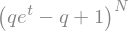

In [4]:
# Define MGF for binomial N, p
mgf = ((1 - q) + q * sympy.exp(t))**N

mgf

As an example let's make sure we can reproduce the known first moment by taking the first derivative.

In [5]:
# Compute first deriative and substitute t = 0.
first_mom = mgf.diff((t,1)).subs({t: 0})

# Simplify and print expression.
first_mom.simplify()

This is indeed the expected value of the binomial distribution.
Let's follow up the analysis, compute the second moment and then the variance

In [6]:
# Compute the second moment and substitute t = 0.
second_mom = mgf.diff((t, 2)).subs({t: 0})

# Compute the variance
var = second_mom - first_mom**2

# Print variance
var.simplify()

Again, the expected variance of the binomial distribution. Now we are in position of computing the rest of the moments systematically.

In [7]:
# Define moments to compute
mom = np.arange(1, 7)

# Initialize list to store moments
mom_list = list()

# Loop through moments and compute derivative
for i in mom:
    # Compute and store derivative
    mom_list.append(mgf.diff((t, i)).subs({t: 0,
                    q: sympy.Rational(1,2)}).expand())

Let's take a look at all the derivatives together.

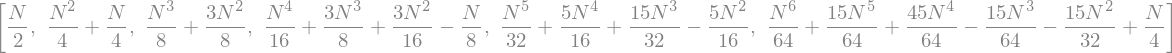

In [8]:
mom_list

What we need to create is a function that for a given pair of exponents $x$ and $y$ computes the product of the two binomials

In [9]:
def binom_prod(x, y):
    '''
    Function that computes the the product of the binomials for a given
    pair of exponents x, y.
    Parameters
    ----------
    x, y : int.
        Exponents of the moment <m**x * p**y>
        
    Returns
    -------
    binom_pro : Sympy eq.
        Product of the two binomial moments
    '''
    # Compute mRNA related moment
    mRNA_mom = mgf.diff((t, x)).subs({t: 0, N: m,
                                      q: sympy.Rational(1,2)})
    
    # Compute protein related moment
    protein_mom = mgf.diff((t, y)).subs({t: 0, N: p,
                                         q: sympy.Rational(1,2)})
    
    # Compute product
    binom_p = mRNA_mom * protein_mom
    
    return binom_p.expand()

Let's look at a couple of examples to gain intuition on these results. For example let's first take a look at the moment $\ee{mp}$.

In [10]:
binom_prod(1, 1)

This result indicates is that when computing the moment after cell division $\ee{mp}_{t_o}$ which is of the form
$$
\ee{mp}_{t_o} = \sum_{m', p'} \ee{m \mid m'} \ee{p \mid p'} P_{t_d}(m', p'),
$$
the product $\ee{m \mid m'} \ee{p \mid p'}$ is then
$$
\ee{m \mid m'} \ee{p \mid p'} = {m' p' \over 4}.
$$
Substituting this result into the moment would then give
$$
\ee{mp}_{t_o} = \sum_{m', p'} {m' p' \over 4} P_{t_d}(m', p') = 
{\ee{m' p'}_{t_d} \over 4}.
$$
Therefore to compute the moment after cell division $\ee{mp}_{t_o}$ we simply have to divide by 4 the same moment before the cell division.

This was an easy example. Let's take a look at another moment, for example $\ee{p^3}$.

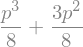

In [11]:
binom_prod(0, 3)

Following the same logic as before this result indicates that in order to compute the moment before cell division $\ee{p^3}_{t_o}$ we would compute
$$
\ee{p^3}_{t_o} = {\ee{p^3}_{t_d} \over 8} + {3 \ee{p^2}_{t_d} \over 8}.
$$
So for this particular case the third moment of the protein distribution depends on the third moment and the second moment before the cell division.

Let us then define a vector to collect all moments before the cell division up  the $\ee{m^x p^y}$, i.e.
$$
\bb{\ee{m^x p^y}}_{t_d} = \left(
\ee{m^0 p^0}_{t_d}, \ee{m^1}_{t_d}, \ldots , \ee{m^x p^y}_{t_d}
\right).
$$
Then the any moment after cell division $\ee{m^{x'}, p^{y'}}_{t_o}$ for $x' \leq x$ and $y' \leq y$ can be computed as
$$
\ee{m^{x'} p^{y'}}_{t_o} = \bb{z}_{x'y'} \cdot \bb{\ee{m^x p^y}}_{t_d},
$$
where we define the vector $\bb{z}_{x'y'}$ as the vector containing all the coefficients that we obtain with the product of the two binomial distributions.
For example for the case of the third protein moment $\ee{p^3}_{t_o}$ the vector $\bb{z}_{x'y'}$ would have zeros for all entries except for the corresponding entry for $\ee{p^2}_{t_d}$ and for $\ee{p^3}_{t_d}$, where it would have $3/8$ and $1/8$ accordingly.

If we want then to compute all the moments after the cell division up to $\ee{m^x p^y}_{t_o}$ let us define an equivalent vector
$$
\bb{\ee{m^x p^y}}_{t_o} = \left(
\ee{m^0 p^0}_{t_o}, \ee{m^1}_{t_o}, \ldots , \ee{m^x p^y}_{t_o}
\right).
$$
Then we need to build a square matrix $\bb{Z}$ such that each row of the matrix contains the corresponding vector $\bb{z}_{x' y'}$ for each of the moments. Having this matrix we would simply compute the moments after the cell division as
$$
\bb{\ee{m^x p^x}}_{t_o} = \bb{Z} \cdot \bb{\ee{m^x p^x}}_{t_d}.
$$
In other words, matrix $\bb{Z}$ will contain all the coefficients that we need to multiply by the moments before the cell division in order to obtain the moments after cell division.

Let's systematically compute this matrix for all the moments up to the 6th protein moment.

### Extract coefficients of polynomial equation.

The first function we need to define is one that takes a result from our `binom_prod` function and extracts all the coefficients into a dictionary. For example if we were to feed the result for the third protein moment $\ee{p^3}$ this function must return a dictionary of the form
$$
\{
p^2: {3 \over 8}, p^3: {1 \over 8}
\}.
$$

In [12]:
def coeff_dictionary(eq):
    '''
    Returns a dictionary with each of the coefficients for a given
    equation.

    Parameter
    ---------
    eq : sympy expression.
        Sympy expression for the equation

    Returns
    -------
    coeff_dict : dictionary.
        Dictionary containing all the coefficients of each of the elements
        in the polynomial equation
    '''
    # Find the degree of the eqent for each of the variables
    if eq.has(m):
        m_degree = sympy.Poly(eq).degree(m)
    else:
        m_degree = 0
    if eq.has(p):
        p_degree = sympy.Poly(eq).degree(p)
    else:
        p_degree = 0
    
    return {m**x * p**y: eq.coeff(m**x * p**y).\
            subs([[m, 0], [p, 0]])
            for x in range(m_degree + 1)
            for y in range(p_degree + 1)}

Let's now test the function

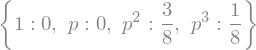

In [13]:
coeff_dictionary(binom_prod(0, 3))

This looks exactly like we expected. Let's look at a slightly more complicated moment such as $\ee{m^3 p^3}$. First we look at the product from the two binomial distributions.

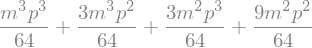

In [14]:
binom_prod(3, 3)

Now we know what entries our dictionary must contain. Let's see if the function actually returns what we expect.

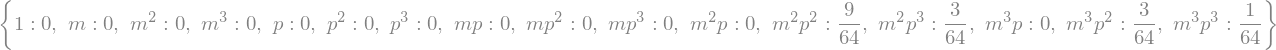

In [15]:
coeff_dictionary(binom_prod(3, 3))

This is indeed the expected dictionary, so the function is working.

### Systematically finding the moments necessary to solve for $\bb{\ee{m^x p^y}}$

We established that a moment of the form $\bb{\ee{m^x p^y}}$ depends on lower moments that satisfy two conditions. We need to define a function that given the largest moment $\bb{\ee{m^x p^y}}$ to be included in the matrix it finds all of the moments $\bb{\ee{m^{x'} p^{y'}}}$ that satisfy such conditions.

In [16]:
def expo_pairs(m_expo, p_expo):
    '''
    Finds all of the pairs of exponents x', y' that are necessary to compute the
    moment <m**m_expo * p**p_expo> that satisfy the necessary conditions:
    1) y' <= p_expo
    2) x' + y' <= m_expo + p_expo
    Parameters
    ----------
    m_expo, p_expo: int.
        Exponents of the highest moment to be included in the system.
        m_expo corresponds to the mRNA exponent
        p_expo corresponds to the protein exponent
        
    Returns
    -------
    pairs : list.
        List of sorted exponent pairs necessary for the computation
    NOTE: The sorting (which is not a necessary feature) given the general
    form of the equation only works up to the moment <m**0 * p**p_expo>.
    Any moment with x'>0 and y'=p_expo will be out of order appended at
    the end of the list.
    '''
    # Find all possible pair of exponents that satisfy
    # x' + y' <= m_expo + p_expo
    expo_pairs = list(itertools.permutations(range(m_expo + p_expo + 1), 2))

    # Add the (num, num) pair that are not being included
    expo_pairs = expo_pairs + [tuple([s, s]) for s in 
                               range(max([m_expo, p_expo]) + 1)]

    # Remove pairs that do not satisfy the condition
    # y' <= p_expo
    expo_pairs = [s for s in expo_pairs if s[1] <= p_expo]

    # Remove pairs that do not satisfy the condition
    # x' <= m_expo + 1
#     expo_pairs = [x for x in expo_pairs if x[0] <= m_expo + 1]

    # # Remove pairs that do not satisfy the condition
    # x' + y' <= m_expo + p_expo
    expo_pairs = [s for s in expo_pairs if sum(s) <= m_expo + p_expo]

    ##  Moment sorting ##
    # Initialize list to append sorted moments
    expo_sorted = list()

    # Append mRNA moments
    mRNA_mom = sorted([s for s in expo_pairs if s[1] == 0])
    expo_sorted.append(mRNA_mom)

    # Find each protein moment
    protein_mom = sorted([s for s in expo_pairs if (s[0] == 0) & (s[1] != 0)])

    # Loop through each protein moment and find the cross correlations
    # associated with it
    for pr in protein_mom:
        cross_corr = sorted([s for s in expo_pairs
                             if (s[0] > 0) & (s[1] > 0) & (sum(s) == pr[1])],
                            reverse=True)
        # append it to the list
        expo_sorted.append(cross_corr)
        expo_sorted.append([pr])

    expo_sorted = list(itertools.chain.from_iterable(expo_sorted))

    # Append the other terms that are missing
    missing = [s for s in expo_pairs if s not in expo_sorted]
    
    return expo_sorted + missing

Let's test the function by finding the moments that would be needed to obtain the second moment of the protein distribution.

In [17]:
# Define exponents for highest moment to be inferred
m_expo, p_expo = 0, 2

# Find the list of moments that need to be computed
expo_pairs(m_expo, p_expo)

These are indeed the moments needed to compute the second protein moment. Now we are ready to generate the matrix $\bb{Z}$. What we need to do is indicate the exponents $x$ and $y$ of the largest moment to be included, obtain all of the moments that are needed in order to compute the this moment, and loop through each of them extracting the coefficients at each step. This is better explained in the implementation of the function.

In [18]:
def Z_matrix_gen(m_expo, p_expo):
    '''
    Generates the matrix A to compute the moment dynamics of the form
    dµ/dt = A * µ
    It is basically a collection of the coefficients that go along
    each moment.
    
    Parameters
    ----------
    m_expo, p_expo: int.
        Exponents of the highest moment to be included in the system.
        m_expo corresponds to the mRNA exponent
        p_expo corresponds to the protein exponent
    
    Returns
    -------
    Z_matrix : 2D-array.
        Sympy matrix containing all of the coefficients to compute the 
        moment after cell division.
    exponents : list.
        List of exponents as they are included in the matrix
    '''
    # Find exponents of moments needed to be computed
    exponents = expo_pairs(m_expo, p_expo)

    # Initalize matrix Z
    Z_matrix = sympy.Matrix(np.zeros([len(exponents),
                                      len(exponents)]))

    # Generate dictionary that saves position of each moment
    # on the matrix
    idx_dict = {e: i for i, e in enumerate(exponents)}

    # Loop through moments 
    for i, (mexp, pexp) in enumerate(exponents):
        # Obtain coefficients of equation
        mom_coeff = coeff_dictionary(binom_prod(mexp, pexp))
        
        # Find row index on matrix Z for substitutions
        row_idx = idx_dict[(mexp, pexp)]
        
        # Loop through coefficients to make substitutions
        for key, value in mom_coeff.items():
            # Find exponents of the moment
            if key.has(m):
                m_degree = sympy.Poly(key).degree(m)
            else:
                m_degree = 0
            if key.has(p):
                p_degree = sympy.Poly(key).degree(p)
            else:
                p_degree = 0

            # Check if moment included in mom_coeff.
            # Sometimes extra moments with no values are added
            if (m_degree, p_degree) in exponents:
                # Find index for columns
                col_idx = idx_dict[(m_degree, p_degree)]
                # Substitute values in corresponding entries
                Z_matrix[row_idx, col_idx] = value
                
    return Z_matrix, exponents

Let's test the function for a simple case. First let's see which moments are needed in order to compute the first protein moment.

In [19]:
# Define exponents for moment
m_exp, p_exp = 0, 1

# Find which moments are needed
pairs = expo_pairs(m_exp, p_exp)
pairs

So we need the moments $\ee{m^0 p^0}$, $\ee{m}$, and $\ee{p}$ in order to compute the first protein moment. Let's then list the resulting products of the binomial products.

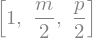

In [20]:
prods = [binom_prod(*x) for x in pairs]
prods

Given these results our function should return a matrix $\bb{Z}$ of the form
$$
\begin{bmatrix}
1 & 0 & 0\\
0 & 1/2 & 0\\
0 & 0 & 1/2
\end{bmatrix}
$$
Let's see if this is what our function actually returns

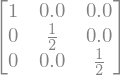

In [21]:
# Generate Z matrix
Z_mat, expo = Z_matrix_gen(0, 1)
Z_mat

That's exactly the matrix we were expecting!

Let's now generate the much larger matrix needed to compute up to the 6th protein moment.

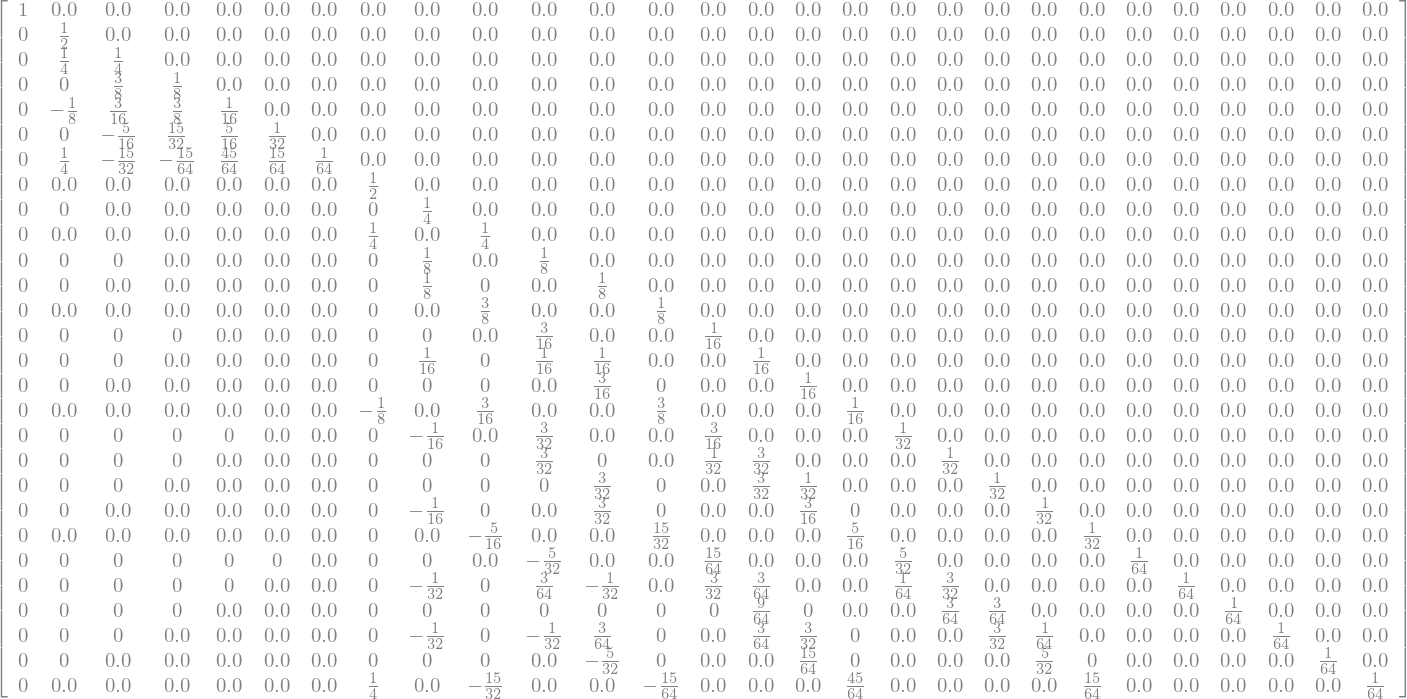

In [22]:
# Define exponents for moment
m_exp, p_exp = 0, 6

# Generate Z matrix
Z_mat, expo = Z_matrix_gen(m_exp, p_exp)
Z_mat

The matrix is what it is, now we just need to save it into a `pickle` object to use it in order to calculate the moments after cell division.

In [23]:
# Export matrix and exponents to file
with open('./pkl_files/binom_coeff_matrix.pkl', 'wb') as file:
    pickle.dump(np.array(Z_mat).astype(np.float64), file)
    pickle.dump(expo, file)